In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from skimage.util import pad
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

In [2]:
# # to much for simple experimentation
# def load_img(fp):
#     img = sitk.ReadImage(fp, sitk.sitkFloat32)
#     # make image square
#     height, width = img.GetSize()
#     top_pad = left_pad = right_pad = bottom_pad = 0
#     delta = abs(height - width)
#     if height < width:
#         left_pad = right_pad = delta // 2
#     else:
#         top_pad = bottom_pad = delta // 2
#     img = sitk.ConstantPad(img, (left_pad, top_pad), (right_pad, bottom_pad), constant=35)
#     # resize
#     return img
# imshow(load_img("/Users/jeremyfisher/Desktop/UAB009-RF.jpg"))

In [3]:
# def threshold_based_crop(image):
#     """
#     Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
#     usually air. Then crop the image using the foreground's axis aligned bounding box.
#     Args:
#         image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
#                                  (the assumption underlying Otsu's method.)
#     Return:
#         Cropped image based on foreground's axis aligned bounding box.                                 
#     """
#     # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
#     # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
#     inside_value = 0
#     outside_value = 255
#     label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
#     label_shape_filter.Execute( sitk.OtsuThreshold(image, inside_value, outside_value) )
#     x, y, height, width = label_shape_filter.GetBoundingBox(outside_value)
#     # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
#     padding = 100
#     res = sitk.RegionOfInterest(image, [height+100, width], [x-100, y])
#     return res

# imgc = threshold_based_crop(img1)
# imshow(imgc)

In [4]:
def load_img(fp):
    im = imread(fp)
    im = rgb2gray(im)
    width, height = im.shape
    if height < width:
        padding = (width - height) // 2
        im = pad(im, padding, mode="edge")
        im = im[padding:padding+width,:]
    im = resize(im, (1024, 1024), anti_aliasing=True)
    return sitk.GetImageFromArray(im)

In [5]:
img1 = load_img("./preprocessed_feets/1.jpg")
img2 = load_img("./preprocessed_feets/UAB040-RF.jpg")
fixed_image, moving_image = img1, img2

In [6]:
def imshow(img):
    plt.imshow(
        sitk.GetArrayViewFromImage(img),
        cmap=plt.cm.Greys_r
    )
def imshow2(img1_, img2_, alpha=0.5):
    plt.imshow(
        sitk.GetArrayViewFromImage((1.0-alpha)*img1_+alpha*img2_),
        cmap=plt.cm.Greys_r
    )

In [7]:
def seg_show(img, seg):
    img_255 = sitk.Cast(sitk.RescaleIntensity(img), sitk.sitkUInt8)
    imshow(sitk.LabelOverlay(img_255, seg))

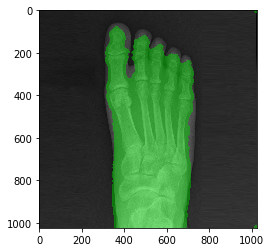

In [8]:
otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(0)
otsu_filter.SetOutsideValue(1)
def preproc(img):
    seg = otsu_filter.Execute(img)
    seg = sitk.BinaryDilate(seg, 25)
    seg = sitk.BinaryErode(seg, 10)
    return seg

seg_show(img1, preproc(img1))

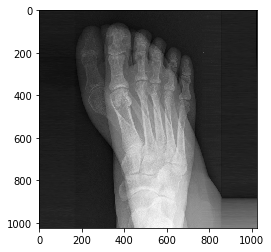

In [9]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image, 
    moving_image, 
    sitk.Euler2DTransform(), 
    sitk.CenteredTransformInitializerFilter.GEOMETRY
)
imshow2(fixed_image, sitk.Resample(
    moving_image,
    fixed_image,
    initial_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID()
))

In [10]:
fixed_image = sitk.Cast(sitk.RescaleIntensity(preproc(fixed_image)), sitk.sitkFloat32)
moving_image = sitk.Cast(sitk.RescaleIntensity(preproc(moving_image)), sitk.sitkFloat32)

In [17]:
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

rm = registration_method.RANDOM
registration_method.SetMetricSamplingStrategy(rm)
registration_method.SetMetricSamplingPercentage(0.1)
registration_method.SetInterpolator(sitk.sitkLinear) # 2. Replace with sitkLinear
registration_method.SetOptimizerAsGradientDescent(learningRate=0.25, numberOfIterations=250) 
registration_method.SetOptimizerScalesFromPhysicalShift() 

# Don't optimize in-place, we would like to run this cell multiple times
registration_method.SetInitialTransform(initial_transform, inPlace=False)

registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOff()


def register():
    final_transform = registration_method.Execute(fixed_image, moving_image)
    return final_transform, registration_method.GetMetricValue()

In [18]:
registrations = []
for _ in range(5):
    transform, metric = register()
    registrations.append((transform, metric))
final_transform, final_metric = min(registrations, key=lambda x: x[1])
final_metric

-0.4418516738376436

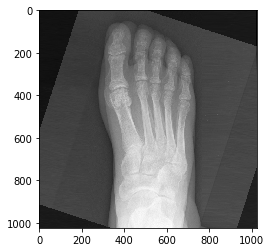

In [22]:
# fixed_image, moving_image = img1, img2
imshow2(img1, sitk.Resample(
    img2,
    img1,
    final_transform,
    sitk.sitkLinear,
    0.0,
    img2.GetPixelID()
))